In [105]:
import time

import numpy as np
from Utils.discrete_family import discrete_family
from Utils.barrier_affine import solve_barrier_tree, solve_barrier_tree_nonneg, solve_barrier_tree_box_PGD
from CART import RegressionTree
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal as mvn
from Utils.plotting import  *
from Utils.simulation_helpers import *
from scipy.stats import norm as ndist

## Testing Approximate Reference

In [106]:
n = 50
p = 5
X = np.random.normal(size=(n, p))
a = 1
b = 1

mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
sd = 1
noise_sd = 1
y = mu + np.random.normal(size=(n,), scale=sd)
# Create and train the regression tree
reg_tree = RegressionTree(min_samples_split=10, max_depth=2, min_proportion=0.2)
reg_tree.fit(X, y, sd = noise_sd)

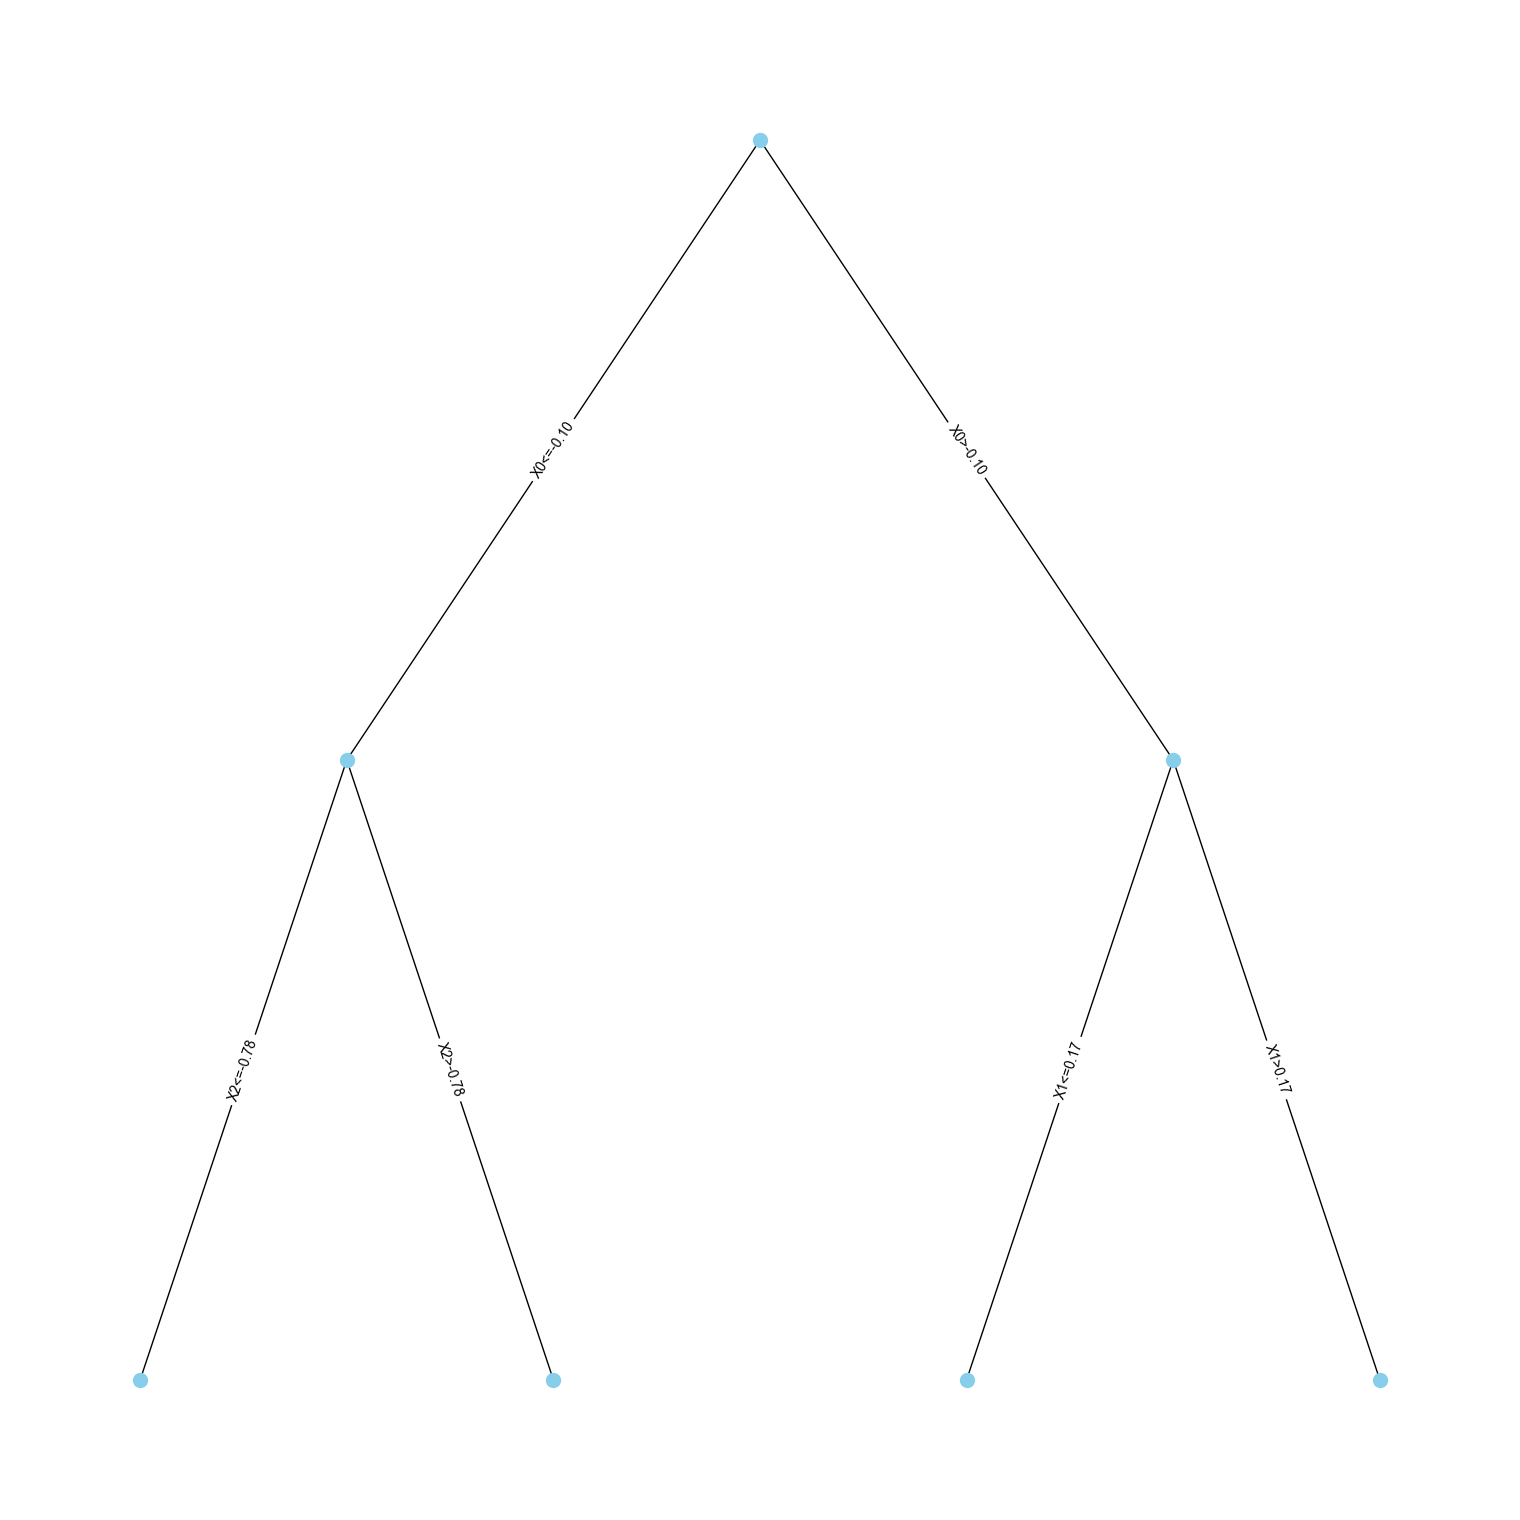

In [107]:
draw_tree(reg_tree.root)

In [108]:
pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs = (
    reg_tree.condl_node_inference(node=reg_tree.root.left.left, 
                                   ngrid=10000,
                                   ncoarse=100,
                                   grid_w_const=1.5,
                                   reduced_dim=1,
                                   sd=sd))

In [109]:
interval = (dist.equal_tailed_interval(observed=norm_contrast.dot(y),
                         alpha=0.1))
np.array(interval) * np.linalg.norm(contrast) * sd
print(pval)

0.30076291761627527


In [110]:
level = 0.1
naive_CI = [norm_contrast.dot(y) - ndist.ppf(1 - level / 2),
            norm_contrast.dot(y) + ndist.ppf(1- level / 2)]
naive_CI

[np.float64(-0.3731024369656477), np.float64(2.916604816937296)]

In [111]:
norm_contrast.dot(y)

np.float64(1.2717511899858243)

In [30]:
obs_tar

np.float64(9.830244016554465)

In [31]:
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

# Select a CRAN mirror to download from
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)  # Select the first mirror

# Install 'remotes' if it's not already installed
if not rpackages.isinstalled('remotes'):
    utils.install_packages(StrVector(('remotes',)))

import rpy2.robjects as ro

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import numpy2ri
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [32]:
# Run the GitHub installation command for 'treevalues'
# ro.r('remotes::install_github("anna-neufeld/treevalues")')

# Activate automatic conversion between pandas and R data frames
pandas2ri.activate()

# Import R libraries
treevalues = importr('treevalues')
rpart = importr('rpart')


# Convert the NumPy matrix to an R matrix
X_r = numpy2ri.py2rpy(X)
y_r = numpy2ri.py2rpy(y)

# Assign the R matrix to a variable in the R environment (optional)
ro.globalenv['X_r'] = X_r
ro.globalenv['y_r'] = y_r
ro.globalenv['p'] = 5

ro.r('data <- cbind(y_r, X_r)')
# Set the column names to "y", "x1", "x2", ..., "x10"
ro.r('colnames(data) <- c("y", paste0("x", 1:p))')
ro.r('data = data.frame(data)')

In [33]:
# Define the rpart tree model
ro.r('bls.tree <- rpart(y ~ ., data=data, model = TRUE, cp=0.00, maxdepth=3)')
bls_tree = ro.r('bls.tree')
# Plot the tree values (this will plot directly if you have a plotting backend set up)
ro.r('treeval.plot(bls.tree, inferenceType=0)')

ro.r('print(row.names(bls.tree$frame)[bls.tree$frame$var == "<leaf>"])')
ro.r('leaf_idx <- (row.names(bls.tree$frame)[bls.tree$frame$var == "<leaf>"])')
leaf_idx = ro.r['leaf_idx']

[1] "4" "5" "6" "7"


In [34]:
leaf_idx

array(['4', '5', '6', '7'], dtype='<U1')

In [35]:
# Get the branch information for a specific branch in the tree (node 11 in this case)
command = 'branch <- getBranch(bls.tree, ' + str(leaf_idx[0]) + ')'
ro.r(command)
ro.r('print(length(branch))')
branch = ro.r('branch')
print(f'Branch: {branch}')
# Perform branch inference
branch_inference_result = ro.r('result <- branchInference(bls.tree, branch, type="reg", alpha = 0.05)')

[1] 2
Branch: ['x1  >= 0.00173641940582477' 'x2  < 0.742159025498082']


In [36]:
# Get confidence intervals
confint = ro.r('result$confint')
print(f'Confidence Interval: {confint}')

# Get p-value
pval = ro.r('result$pval')
print(f'P-Value: {pval}')

Confidence Interval: [-1.41362497  2.8982291 ]
P-Value: [0.44967845]


In [37]:
confint[0]

np.float64(-1.4136249722091212)

In [38]:
# Get terminal nodes
ro.r('terminal_nodes <- as.numeric(rownames(bls.tree$frame[bls.tree$frame$var == "<leaf>", ]))')

In [39]:
terminal_nodes = ro.r('terminal_nodes')

In [40]:
terminal_nodes

array([4., 5., 6., 7.])

In [41]:
ro.r('idx_full <- 1:nrow(bls.tree$frame)')
ro.r('mapped_idx <- idx_full[bls.tree$frame$var == "<leaf>"]')

In [43]:
print(terminal_nodes)

[4. 5. 6. 7.]


In [359]:
def tree_values_inference(X, y, mu, sd_y, max_depth=5):
    # Convert the NumPy matrix to an R matrix
    X_r = numpy2ri.py2rpy(X)
    y_r = numpy2ri.py2rpy(y)
    
    # Assign the R matrix to a variable in the R environment (optional)
    ro.globalenv['X_r'] = X_r
    ro.globalenv['y_r'] = y_r
    ro.globalenv['p'] = X.shape[1]
    
    # Construct dataset
    ro.r('data <- cbind(y_r, X_r)')
    # Set the column names to "y", "x1", "x2", ..., "x10"
    ro.r('colnames(data) <- c("y", paste0("x", 1:p))')
    ro.r('data = data.frame(data)')
    
    # Define the rpart tree model
    tree_cmd = 'bls.tree <- rpart(y ~ ., data=data, model = TRUE, cp=0.00, maxdepth=' + str(max_depth) + ')'
    ro.r(tree_cmd)
    bls_tree = ro.r('bls.tree')
    # Plot the tree values (this will plot directly if you have a plotting backend set up)
    #ro.r('treeval.plot(bls.tree, inferenceType=0)')
    
    #ro.r('print(row.names(bls.tree$frame)[bls.tree$frame$var == "<leaf>"])')
    ro.r('leaf_idx <- (row.names(bls.tree$frame)[bls.tree$frame$var == "<leaf>"])')
    leaf_idx = ro.r['leaf_idx']
    
    # Get node mapping
    ro.r('idx_full <- 1:nrow(bls.tree$frame)')
    ro.r('mapped_idx <- idx_full[bls.tree$frame$var == "<leaf>"]')
    
    len = []
    coverage = []
    len_naive = []
    coverage_naive = []
    
    for i,idx in enumerate(leaf_idx):
        # Get the branch information for a specific branch in the tree
        command = 'branch <- getBranch(bls.tree, ' + str(idx) + ')'
        ro.r(command)
        # Perform branch inference
        ro.r('result <- branchInference(bls.tree, branch, type="reg", alpha = 0.10)')
        # Get confidence intervals
        confint = ro.r('result$confint')
        len.append(confint[1] - confint[0])
    
        target_cmd = "contrast <- (bls.tree$where == mapped_idx[" + str(i+1) + "])"
        ro.r(target_cmd)
        contrast = ro.r('contrast')
        contrast = np.array(contrast)
        
        contrast = np.array(contrast * 1 / np.sum(contrast))
        
        target = contrast.dot(mu)
        coverage.append(target >= confint[0] and target <= confint[1])
        
        # Naive after tree value
        # Confidence intervals
        naive_CI = [contrast.dot(y) - 
                    np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2),
                    contrast.dot(y) + 
                    np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2)]
        coverage_naive.append((target >= naive_CI[0] and target <= naive_CI[1]))
        len_naive.append(naive_CI[1] - naive_CI[0])
        
    return np.mean(coverage), np.mean(len), np.mean(coverage_naive), np.mean(len_naive)

In [360]:
coverage, avg_len, coverage_tn, avg_len_tn = tree_values_inference(X, y, mu, 3)

In [361]:
import time

In [371]:
def terminal_inference_sim(n = 50, p = 5, a = 0.1, b = 0.1, 
                       sd_y = 1, noise_sd = 1, start=0, end=100,
                       level=0.1):
    pivots = []
    naive_pivots = []
    
    coverage = []
    naive_coverage = []
    tree_val_coverage = []
    treeval_naive_coverage = []
    
    lengths = []
    naive_lengths = []
    tree_val_lengths = []
    treeval_naive_lengths = []
    
    for i in range(start, end):
        print(i, "th simulation")
        np.random.seed(i + 48105)
        X = np.random.normal(size=(n, p))

        mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
        y = mu + np.random.normal(size=(n,), scale=sd_y)
        # Create and train the regression tree
        reg_tree = RegressionTree(min_samples_split=10, max_depth=2,
                                  min_proportion=0.1)
        reg_tree.fit(X, y, sd = noise_sd)
        
        coverage_i = []
        naive_coverage_i = []
        lengths_i = []
        naive_lengths_i = []
        #print(reg_tree.terminal_nodes)
        start_ours = time.time()
        for node in reg_tree.terminal_nodes:
            pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs \
                = (reg_tree.condl_node_inference(node=node, 
                                                 ngrid=10000,
                                                 ncoarse=400,
                                                 grid_w_const=3,
                                                 reduced_dim=1,
                                                 sd=sd_y,
                                                 use_cvxpy=True))
        
            norm_target = norm_contrast.dot(mu)
            pivot_i = dist.ccdf(theta=norm_target, x=obs_tar)
            pivots.append(pivot_i)
            
            target = contrast.dot(mu)
            naive_pivot = Z_test(y=y, norm_contrast=contrast, null=target, 
                                 sd = np.linalg.norm(contrast) * sd_y)
            naive_pivots.append(naive_pivot)
            
            # Confidence intervals
            naive_CI = [contrast.dot(y) - 
                        np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2),
                        contrast.dot(y) + 
                        np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2)]
            naive_coverage_i.append((target >= naive_CI[0] and target <= naive_CI[1]))
            naive_lengths_i.append(naive_CI[1] - naive_CI[0])
            
            #print("Naive Length:", 2*sd_y*ndist.ppf(1 - level / 2))
            
            # This is an interval for
            # eta_*'mu = eta'mu / (norm(eta) * sd_y)
            selective_CI = (dist.equal_tailed_interval(observed=norm_contrast.dot(y),
                                                       alpha=level))
            selective_CI = np.array(selective_CI)
            selective_CI *= np.linalg.norm(contrast) * sd_y
            #print("sci", selective_CI)
            coverage_i.append((target >= selective_CI[0] and target <= selective_CI[1]))
            #norm_target = norm_contrast.dot(mu)
            #coverage_i.append((norm_target >= selective_CI[0] and norm_target <= selective_CI[1]))
            lengths_i.append(selective_CI[1] - selective_CI[0])
            
            #"""
            print("selective CI:", selective_CI)
            print("naive CI:", naive_CI)
            print("target:", target)
            print("observed target:", obs_tar)#"""
        end_ours = time.time()
        print("Ours took:", end_ours - start_ours)
            
        coverage.append(np.mean(coverage_i))
        lengths.append(np.mean(lengths_i))
        naive_coverage.append(np.mean(naive_coverage_i))
        naive_lengths.append(np.mean(naive_lengths_i))
        
        
        start_treeval = time.time()
        # Tree value
        (coverage_treeval, avg_len_treeval, 
         coverage_treeval_naive, avg_len_treeval_naive) \
            = tree_values_inference(X, y, mu, sd_y=sd_y, max_depth=2)
        tree_val_coverage.append(coverage_treeval)
        tree_val_lengths.append(avg_len_treeval)
        treeval_naive_coverage.append(coverage_treeval_naive)
        treeval_naive_lengths.append(avg_len_treeval_naive)
        end_treeval = time.time()
        
        print("Tree took:", end_treeval - start_treeval)
        
    
    return (pivots, naive_pivots, 
            coverage, lengths, naive_coverage, naive_lengths, 
            tree_val_coverage, tree_val_lengths, 
            treeval_naive_coverage, treeval_naive_lengths)

In [ ]:
(pivots, naive_pivots, coverage, lengths, 
 naive_coverage, naive_lengths, 
 tree_val_coverage, tree_val_lengths,
treeval_naive_coverage, treeval_naive_lengths) \
    = terminal_inference_sim(start=0, end=100, n=200, p=10, sd_y=5, noise_sd=2, 
                             a=1,b=1, level=0.1)

0 th simulation
selective CI: [-27.25754172  10.03221748]
naive CI: [np.float64(1.185351966387021), np.float64(4.093069850578705)]
target: 1.6875
observed target: 2.985926288591586


In [365]:
print(np.mean(coverage))
print(np.mean(naive_coverage))
print(np.mean(tree_val_coverage))
print(np.mean(treeval_naive_coverage))
print(np.mean(lengths))
print(np.mean(naive_lengths))
print(np.mean(tree_val_lengths))
print(np.mean(treeval_naive_lengths))

0.8032142857142859
0.4266071428571428
0.9067619047619047
0.38676190476190475
185.93826522062236
4.458844785314544
inf
3.7802572343062417


In [366]:
def plot_ecdfs(data_list, labels, title=None):
    # Step 2: Sort the data
    sorted_data = []
    for data in data_list:
        data_sorted = np.sort(data)
        sorted_data.append(data_sorted)

    # Step 3: Calculate the empirical CDF
    # For each point, the CDF value is the proportion of data points less than or equal to that point
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

    # Step 4: Plot the empirical CDF
    plt.figure(figsize=(6, 6))
    for i, data in enumerate(sorted_data):
        plt.step(data, cdf_values, where='post',
                 label=labels[i])
    if not title:
        plt.title('Empirical Cumulative Distribution Function')
    else:
        plt.title(title)
    # Add a y=x line
    plt.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()

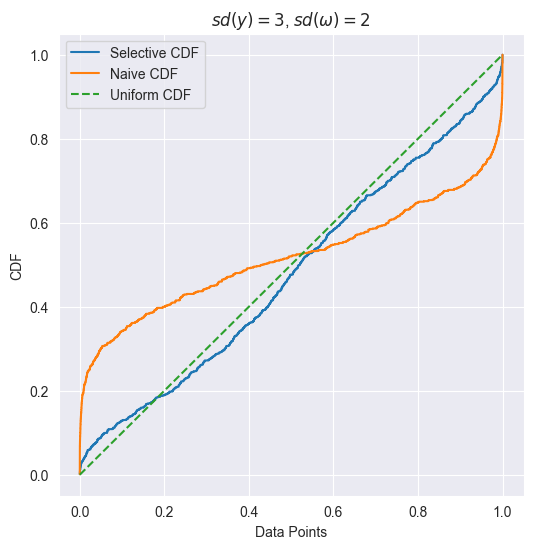

In [367]:
plot_ecdfs([pivots, naive_pivots], ["Selective CDF", "Naive CDF"],
           title="$sd(y)=3$, $sd(\omega) = 2$")

In [368]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics_boxplots(metrics_dict):
    """
    Plots boxplots for coverage and length for the given metrics_dict.
    
    Args:
    metrics_dict: dict 
        A dictionary containing the methods as keys ('naive', 'selective', 'treeval')
        Each method has another dict as its value with 'coverage' and 'length' as keys 
        and lists of aggregated simulation results as values.
    """
    
    # Convert the dictionary into a DataFrame for easy plotting
    data = []
    for method, metrics in metrics_dict.items():
        for coverage, length in zip(metrics['coverage'], metrics['length']):
            data.append({'method': method, 'coverage': coverage, 'length': length})

    df = pd.DataFrame(data)
    
    # Create two subplots: one for coverage and one for length
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Boxplot for coverage
    axs[0].set_title('Coverage')
    df.boxplot(column='coverage', by='method', ax=axs[0])
    axs[0].set_xlabel('Method')
    axs[0].set_ylabel('Coverage')
    
    # Boxplot for length
    axs[1].set_title('Length')
    df.boxplot(column='length', by='method', ax=axs[1])
    axs[1].set_xlabel('Method')
    axs[1].set_ylabel('Length')

    plt.suptitle('Boxplots of Coverage and Length by Method')
    plt.tight_layout()
    plt.show()


In [369]:
metrics_dict = {
    'selective+naive': {'coverage': naive_coverage, 'length': naive_lengths},
    'selective': {'coverage': coverage, 'length': lengths},
    'treeval': {'coverage': tree_val_coverage, 'length': tree_val_lengths},
    'treeval+naive': {'coverage': treeval_naive_coverage, 'length': treeval_naive_lengths}
}

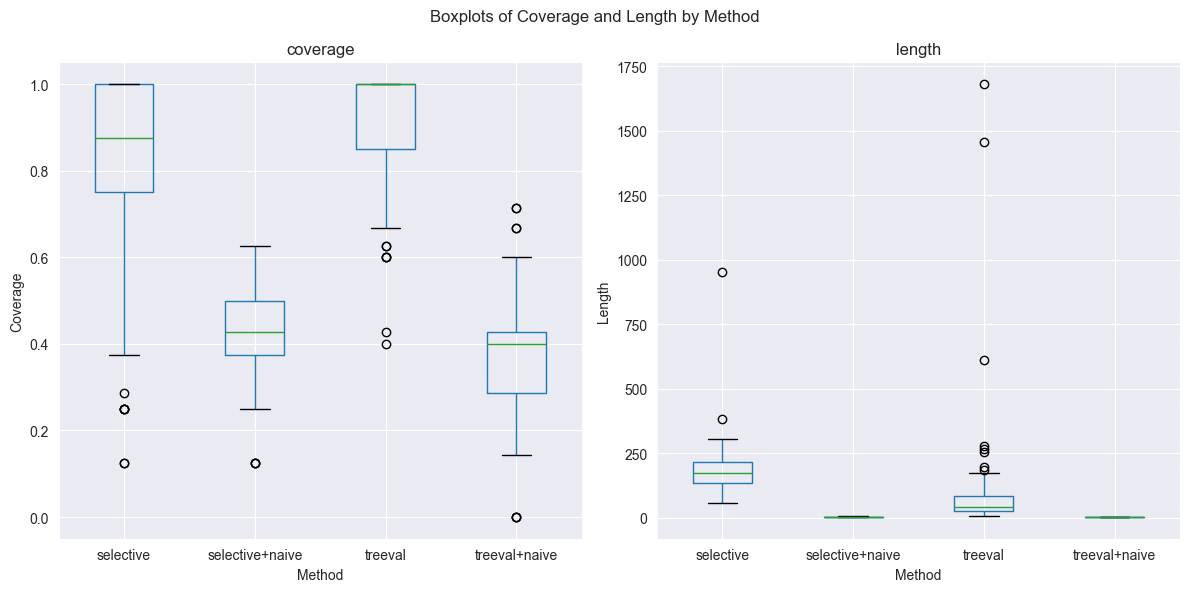

In [370]:
plot_metrics_boxplots(metrics_dict)

2# Testing Randomization Scale

In [341]:
np.random.seed(1234)
n = 200
p = 10
X = np.random.normal(size=(n, p))
a = 1
b = 1

mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
sd_y = 5
noise_sd = sd_y*0.5
level = 0.1
y = mu + np.random.normal(size=(n,), scale=sd)
# Create and train the regression tree
reg_tree = RegressionTree(min_samples_split=10, max_depth=3, min_proportion=0.1)
reg_tree.fit(X, y, sd = noise_sd)

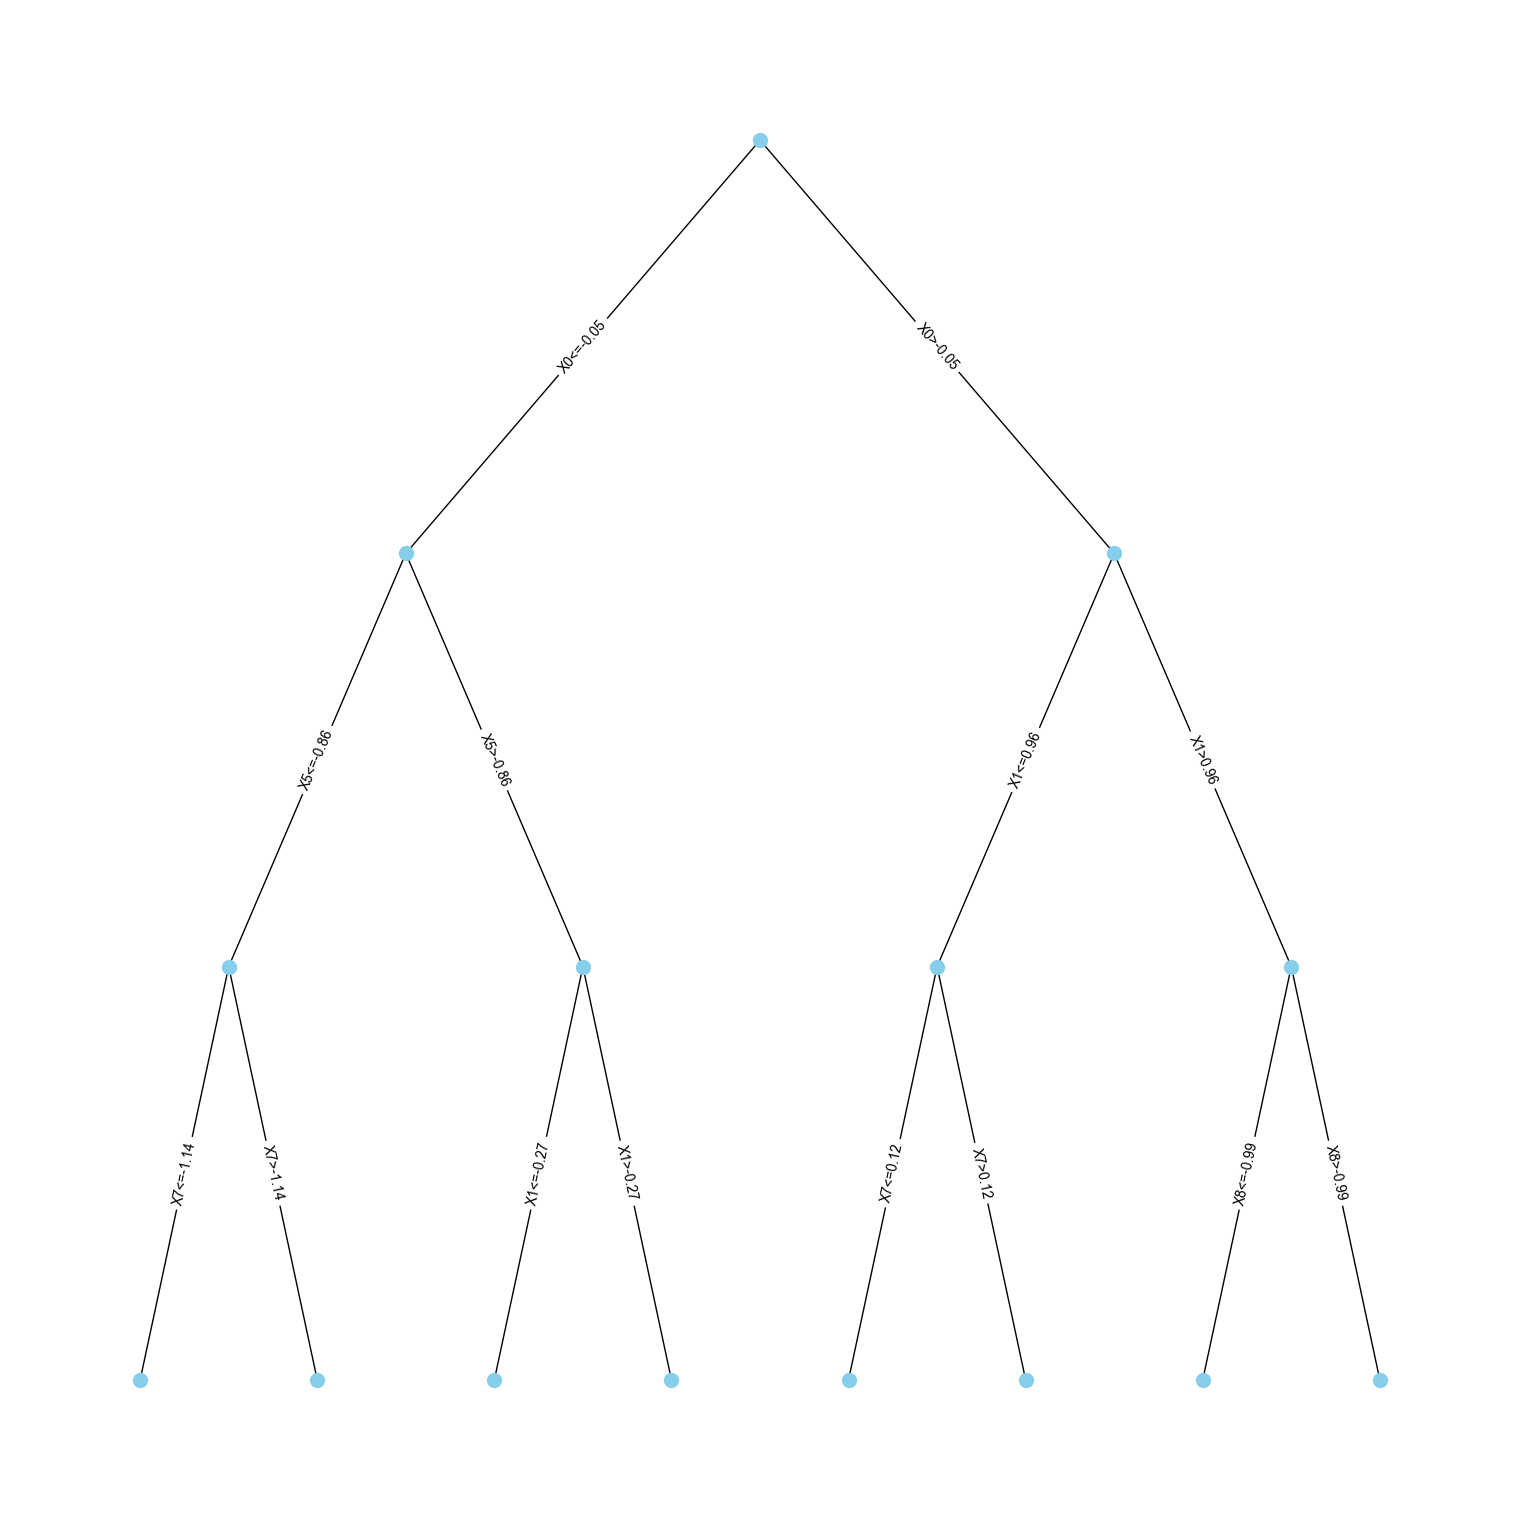

In [342]:
draw_tree(reg_tree.root)

In [343]:
node = reg_tree.root.left.right.right
node.membership.sum()

np.float64(35.0)

In [344]:
width_const = 1.5
pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs \
    = (reg_tree.condl_node_inference(node=node, 
                                     ngrid=10000,
                                     ncoarse=200,
                                     grid_w_const=width_const,
                                     reduced_dim=1,
                                     sd=sd_y,
                                     use_cvxpy=True))

norm_target = norm_contrast.dot(mu)
pivot_i = dist.ccdf(theta=norm_target, x=obs_tar)
pivots.append(pivot_i)

target = contrast.dot(mu)

# This is an interval for
# eta_*'mu = eta'mu / (norm(eta) * sd_y)
selective_CI = (dist.equal_tailed_interval(observed=norm_contrast.dot(y),
                                           alpha=level))
selective_CI = np.array(selective_CI)
selective_CI *= np.linalg.norm(contrast) * sd_y

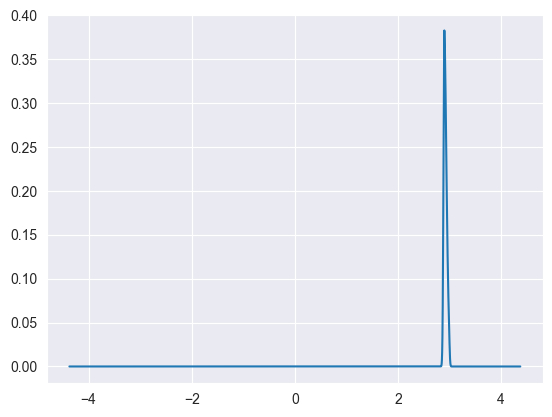

In [345]:
import matplotlib.pyplot as plt
x = np.linspace(-width_const * np.abs(obs_tar), width_const * np.abs(obs_tar), 10000)
plt.plot(x, np.exp(sel_probs))

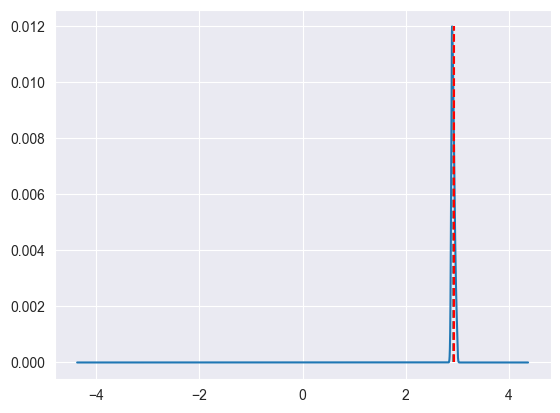

In [346]:
plt.plot(x, dist.pdf(theta=norm_contrast.dot(mu)))
plt.vlines(obs_tar, ymin=0, ymax=np.max(dist.pdf(theta=norm_contrast.dot(mu))),
           linestyles='--', colors='grey')
plt.vlines(norm_contrast.dot(mu), ymin=0, 
           ymax=np.max(dist.pdf(theta=norm_contrast.dot(mu))),
           linestyles='--', colors='red')

In [347]:
intv = dist.equal_tailed_interval(observed=norm_contrast.dot(y),
                                  alpha=0.1) 

In [348]:
intv

(np.float64(-62.20269977053401), np.float64(51.233521334450046))

In [349]:
np.array(intv) * np.linalg.norm(contrast) * sd_y

array([-52.57087637,  43.30022854])

In [283]:
def tree_values_inference(X, y, mu, sd_y, max_depth=5, level=0.1,
                          X_test=None):
    # Convert the NumPy matrix to an R matrix
    X_r = numpy2ri.py2rpy(X)
    y_r = numpy2ri.py2rpy(y)
    
    # Assign the R matrix to a variable in the R environment (optional)
    ro.globalenv['X_r'] = X_r
    ro.globalenv['y_r'] = y_r
    ro.globalenv['p'] = X.shape[1]
    
    # Construct dataset
    ro.r('data <- cbind(y_r, X_r)')
    # Set the column names to "y", "x1", "x2", ..., "x10"
    ro.r('colnames(data) <- c("y", paste0("x", 1:p))')
    ro.r('data = data.frame(data)')
    
    # Define the rpart tree model
    tree_cmd = 'bls.tree <- rpart(y ~ ., data=data, model = TRUE, cp=0.00, maxdepth=' + str(max_depth) + ')'
    ro.r(tree_cmd)
    bls_tree = ro.r('bls.tree')
    # Plot the tree values (this will plot directly if you have a plotting backend set up)
    #ro.r('treeval.plot(bls.tree, inferenceType=0)')
    
    #ro.r('print(row.names(bls.tree$frame)[bls.tree$frame$var == "<leaf>"])')
    ro.r('leaf_idx <- (row.names(bls.tree$frame)[bls.tree$frame$var == "<leaf>"])')
    leaf_idx = ro.r['leaf_idx']
    
    # Get node mapping
    ro.r('idx_full <- 1:nrow(bls.tree$frame)')
    ro.r('mapped_idx <- idx_full[bls.tree$frame$var == "<leaf>"]')
    
    len = []
    coverage = []
    len_naive = []
    coverage_naive = []
    
    for i,idx in enumerate(leaf_idx):
        # Get the branch information for a specific branch in the tree
        command = 'branch <- getBranch(bls.tree, ' + str(idx) + ')'
        ro.r(command)
        # Perform branch inference
        ro.r('result <- branchInference(bls.tree, branch, type="reg", alpha = 0.10)')
        # Get confidence intervals
        confint = ro.r('result$confint')
        len.append(confint[1] - confint[0])
    
        target_cmd = "contrast <- (bls.tree$where == mapped_idx[" + str(i+1) + "])"
        ro.r(target_cmd)
        contrast = ro.r('contrast')
        contrast = np.array(contrast)
        
        contrast = np.array(contrast * 1 / np.sum(contrast))
        
        target = contrast.dot(mu)
        coverage.append(target >= confint[0] and target <= confint[1])
        
        # Naive after tree value
        # Confidence intervals
        naive_CI = [contrast.dot(y) - 
                    np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2),
                    contrast.dot(y) + 
                    np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2)]
        coverage_naive.append((target >= naive_CI[0] and target <= naive_CI[1]))
        len_naive.append(naive_CI[1] - naive_CI[0])
    
    if X_test is not None:
        X_test_r = numpy2ri.py2rpy(X_test)
        ro.globalenv['X_test_r'] = X_test_r
        ro.r('pred <- predict(bls.tree, data = X_test_r)')
        pred = ro.r['pred']
    else:
        pred = None
        
    return (np.mean(coverage), np.mean(len), 
            np.mean(coverage_naive), np.mean(len_naive), pred) 

In [284]:
# Tree value & naive inference & prediction
(coverage_treeval, avg_len_treeval, 
 coverage_treeval_naive, avg_len_treeval_naive,
 pred_test_treeval) = tree_values_inference(X, y, mu, sd_y=sd_y, 
                                            X_test=X, max_depth=3)

In [285]:
avg_len_treeval

np.float64(10.768381637504772)

In [286]:
avg_len_treeval_naive

np.float64(3.547861427270288)

In [300]:
pivot_i = dist.ccdf(theta=54,#norm_contrast.dot(mu), 
                    x=obs_tar)

In [301]:
pivot_i

np.float64(0.9484328190707386)